In [275]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import datetime
import json
import requests

In [276]:
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

# Check available GPUs
gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"GPU is available with {gpu_count} GPU(s).")
else:
    print("No GPU detected. Ensure your setup is correct.")

# Test CatBoost with GPU
try:
    model = CatBoostClassifier(task_type="GPU", devices='0')  # Specify GPU
    device = 'cuda'
    print("CatBoost can use the GPU.")
        
except Exception as e:
    device = 'cpu'
    print(f"Error: {e}")

GPU is available with 1 GPU(s).
CatBoost can use the GPU.


In [277]:
# Declare important variables
train_path = 'Game_Win_Classifier_Transformed.csv'
test_path = 'Game_Win_Classifier_Predict.csv'
target_variable = 'win_or_lose_Home'
SEED = 69
skip_hypertuning = True

In [278]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    print(f"Loading data from {os.getcwd()}")
    
    return df1, df2

In [279]:
df_train, df_test = load_dataframes(train_path,test_path)

Loading data from C:\Users\ZaneC\OneDrive\Documents\Python\NHL Model


In [280]:
df_train = df_train.drop(columns=['team_Home','team_Away','gameId','home_or_away_Home','home_or_away_Away','win_or_lose_Away'])
df_test = df_test.drop(columns=['goalieId_Home','goalieName_Home','goalieId_Away','goalieName_Away'])

In [281]:
df_train = df_train.rename(columns={target_variable: 'y'})

In [282]:
def get_num_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['number']).columns.to_list()
    
    return num_cols

def get_cat_cols(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()  

    return cat_cols

In [283]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()   
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    inf['count'] = df.shape[0]

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [284]:
describe_dataframe(df_train, name='NHL Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev
0,y,int64,0,0.000000,2,0,5000,0.000000,1.000000,0.535400,0.498795
1,seasonPointsPerGame_Home,float64,0,0.000000,1411,0,5000,0.090909,2.000000,1.002873,0.255624
2,xGoalsPercentageAvg_Home,float64,0,0.000000,38,0,5000,0.310000,0.720000,0.499122,0.057789
3,corsiPercentageAvg_Home,float64,0,0.000000,29,0,5000,0.360000,0.640000,0.499334,0.043654
4,fenwickPercentageAvg_Home,float64,0,0.000000,30,0,5000,0.350000,0.650000,0.499340,0.043815
5,xOnGoalForAvg_Home,float64,0,0.000000,1388,0,5000,20.520000,42.750000,31.058162,3.339925
6,xGoalsForAvg_Home,float64,0,0.000000,276,0,5000,1.790000,5.410000,3.054644,0.494001
7,xReboundsForAvg_Home,float64,0,0.000000,160,0,5000,1.390000,3.100000,2.144868,0.259019
8,xFreezeForAvg_Home,float64,0,0.000000,455,0,5000,4.670000,10.280000,7.250150,0.877709
9,xPlayStoppedForAvg_Home,float64,0,0.000000,77,0,5000,0.650000,1.470000,1.031718,0.120175


In [285]:
# df_train.hist(bins=50, figsize=(20,15))
# plt.show()

In [286]:
# num_cols = get_num_cols(df_train)

# plt.figure(figsize=(20,10))
# sns.heatmap(df_train[num_cols].corr(),
#             vmin=-1,
#             vmax=1,
#             center=0,
#             annot=True,
#             cmap='PRGn')
# plt.show()

In [287]:
from scipy.stats import f_oneway

def anova_test(data, cat_cols, target):
    anova_res = []
    for col in cat_cols:
        groups = [data[target][data[col] == cat] for cat in data[col].unique()]
        f_stat, p_val = f_oneway(*groups)
        anova_res.append([col, f_stat, p_val])
    return anova_res

In [288]:
# Sort predictive categorical columns
cat_cols = get_cat_cols(df_train.drop('y', axis=1))

anova_res = anova_test(df_train, cat_cols, 'y')
anova_df = pd.DataFrame(anova_res, columns = ['Column', 'F Statistic', 'P-value'])
anova_df = anova_df.sort_values(ascending = False, by = 'P-value')
anova_df

,Column,F Statistic,P-value


In [289]:
# Sort predictive numerical columns
num_cols = get_num_cols(df_train)

corr_col = df_train[num_cols].corr()['y'].drop(['y'])
corr_df = corr_col.reset_index()
corr_df.columns = ['Columns', 'Correlation']
corr_df = corr_df.sort_values(ascending = False, by = 'Correlation').reset_index(drop=True)
corr_df

,Columns,Correlation
0,seasonPointsPerGame_Home,0.269838
1,beforeGameSeasonGAA_Away,0.052412
2,lowDangerShotsForAvg_Away,0.044076
3,xFreezeForAvg_Away,0.043557
4,missedShotsForAvg_Away,0.043017
...,...,...
201,scoreFlurryAdjustedTotalShotCreditAgainstAvg_Away,-0.039404
202,scoreAdjustedTotalShotCreditAgainstAvg_Away,-0.040947
203,pointsFromGameAvg_Home,-0.050477
204,beforeGameSeasonGAA_Home,-0.076764


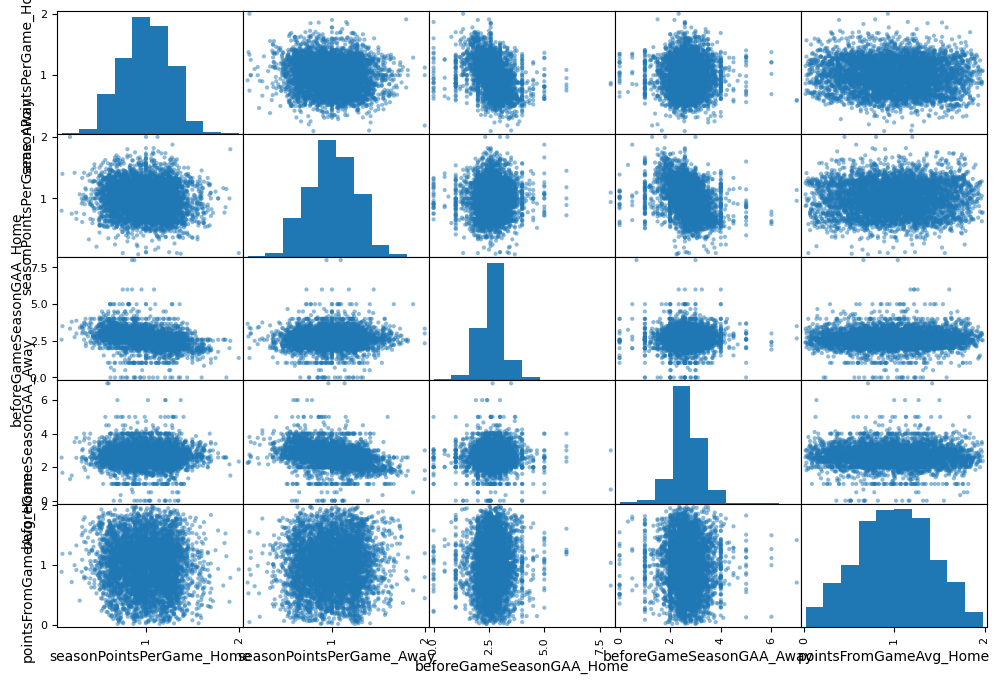

In [290]:
#Visualize for multicollinearity 
from pandas.plotting import scatter_matrix

sel_num_top_5 = np.array(
    corr_df.loc[np.abs(corr_df['Correlation']).nlargest(5).index, 'Columns']
)

#high_corr_num = np.array(corr_df[np.abs(corr_df['Correlation']) > 0.2]['Columns'])
scatter_matrix(df_train[sel_num_top_5], figsize=(12,8));

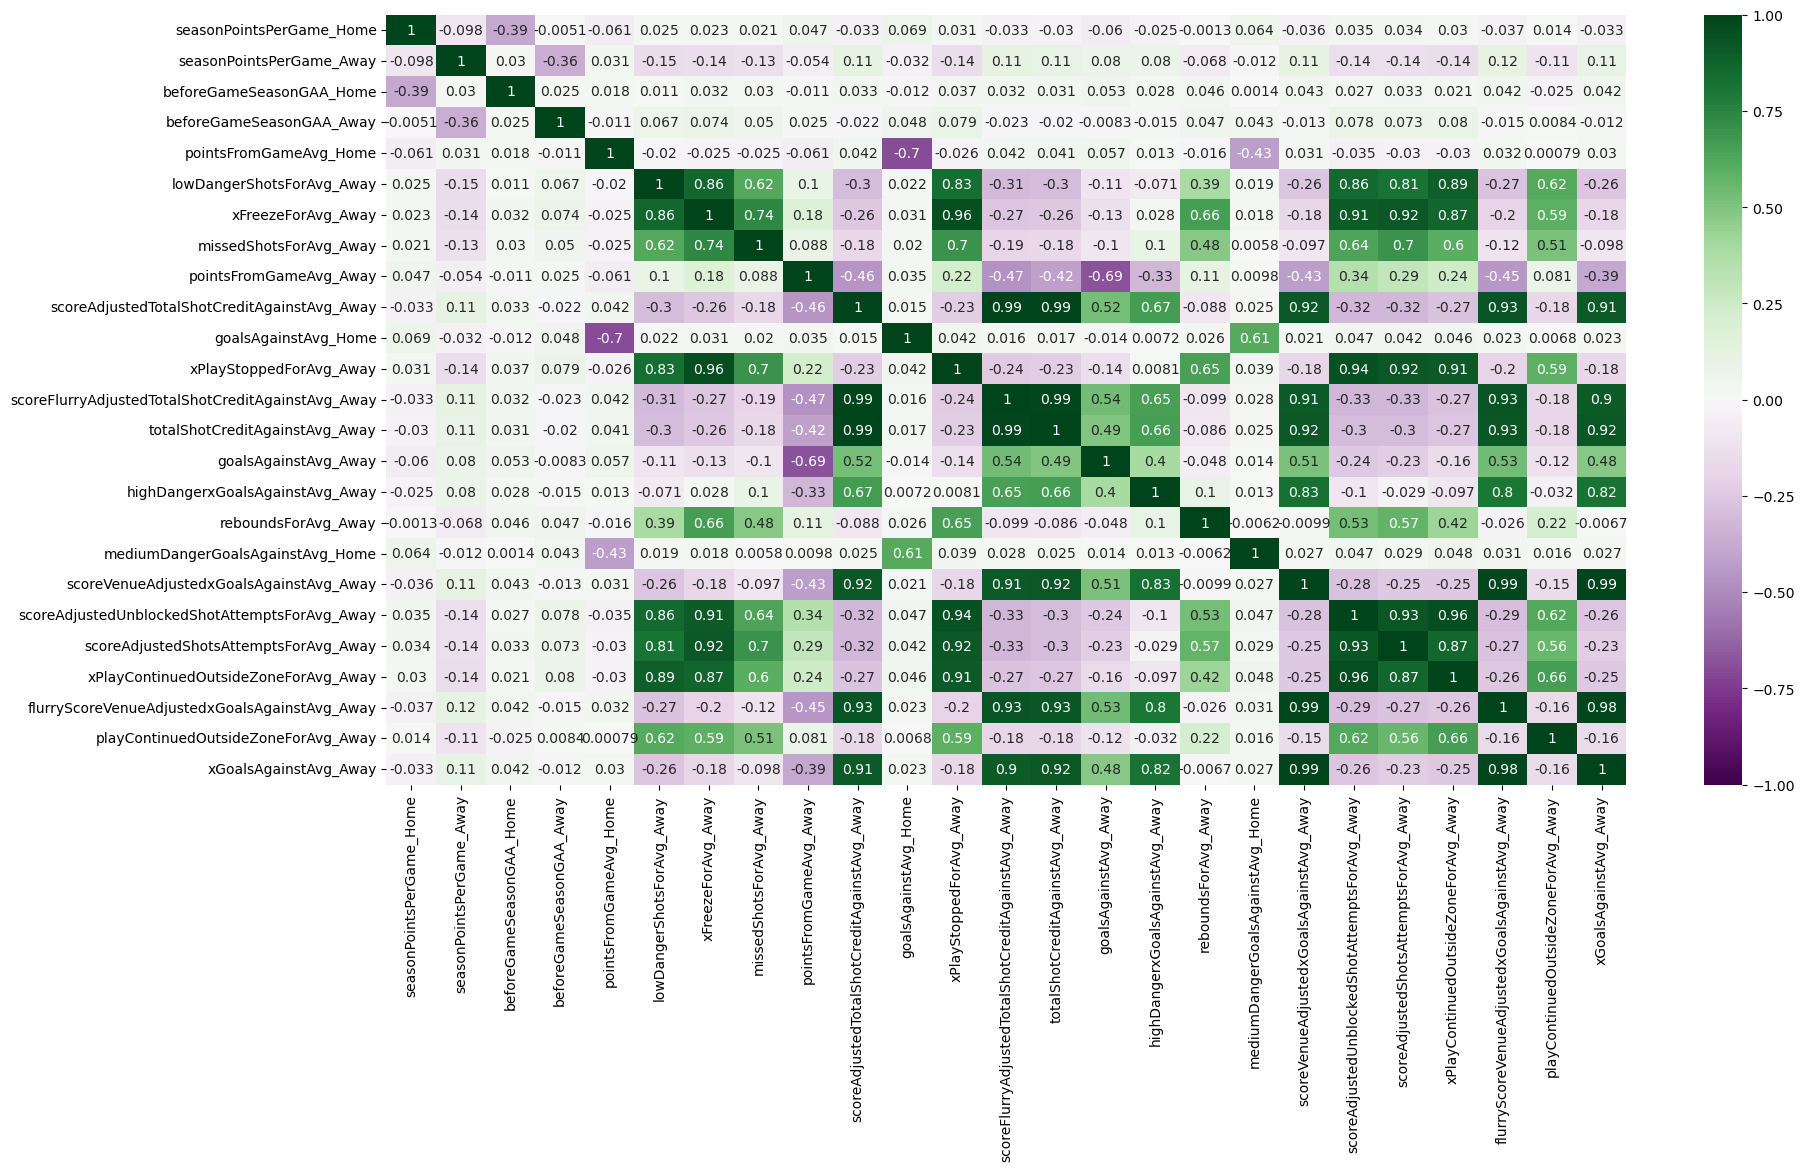

In [291]:
sel_num_top_25 = np.array(
    corr_df.loc[np.abs(corr_df['Correlation']).nlargest(25).index, 'Columns']
)

plt.figure(figsize=(20,10))
sns.heatmap(df_train[sel_num_top_25].corr(),
            vmin=-1,
            vmax=1,
            center=0,
            annot=True,
            cmap='PRGn')
plt.show()

In [292]:
# Select best numerical and categorical colums 
sel_cat = np.array(anova_df[anova_df['P-value'] < 0.03]['Column'])
sel_cat = get_cat_cols(df_train.drop('y', axis=1))

sel_num = np.array(corr_df[np.abs(corr_df['Correlation']) > 0.03]['Columns'])
sel_num = get_num_cols(df_train.drop('y', axis=1))

#best_cols = np.append(sel_num, sel_cat)

In [293]:
# Split home and away features
top_home_columns = [col for col in df_train[sel_num].columns if col.endswith('_Home')]
top_away_columns = [col for col in df_train[sel_num].columns if col.endswith('_Away')]

In [294]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Filters out high VIF Home features

# Standardize features
X = df_train[top_home_columns]  # Excludes the target column
X_scaled = StandardScaler().fit_transform(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Sort the DataFrame by 'VIF' in ascending order
vif_data = vif_data.sort_values(by='VIF')

# Filter the DataFrame to include only the rows where VIF is below the threshold
low_vif_home_features = vif_data[vif_data['VIF'] <= 10]

# Display the selected features
print(low_vif_home_features)

                           Feature       VIF
0         seasonPointsPerGame_Home  1.263013
30                 hitsForAvg_Home  1.406628
78             hitsAgainstAvg_Home  1.539322
77      faceOffsWonAgainstAvg_Home  1.793342
79        takeawaysAgainstAvg_Home  1.820047
31            takeawaysForAvg_Home  1.877229
29          faceOffsWonForAvg_Home  1.895513
20         reboundGoalsForAvg_Home  2.002544
68     reboundGoalsAgainstAvg_Home  2.055195
101   beforeGameSesaonSavePct_Home  2.586067
102       beforeGameSeasonGAA_Home  2.860265
45       dZoneGiveawaysForAvg_Home  5.783598
93   dZoneGiveawaysAgainstAvg_Home  6.017017
100         pointsFromGameAvg_Home  6.227286
32            giveawaysForAvg_Home  7.348835
80        giveawaysAgainstAvg_Home  7.806961


In [295]:
# Filters out high VIF Away features

# Standardize features
X = df_train[top_away_columns]  # Excludes the target column
X_scaled = StandardScaler().fit_transform(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Sort the DataFrame by 'VIF' in ascending order
vif_data = vif_data.sort_values(by='VIF')

# Filter the DataFrame to include only the rows where VIF is below the threshold
low_vif_away_features = vif_data[vif_data['VIF'] <= 10]

# Display the selected features
print(low_vif_away_features)

                           Feature       VIF
0         seasonPointsPerGame_Away  1.246867
30                 hitsForAvg_Away  1.428097
78             hitsAgainstAvg_Away  1.523125
77      faceOffsWonAgainstAvg_Away  1.850614
79        takeawaysAgainstAvg_Away  1.876834
31            takeawaysForAvg_Away  1.899893
101   beforeGameSesaonSavePct_Away  1.964780
68     reboundGoalsAgainstAvg_Away  2.006692
29          faceOffsWonForAvg_Away  2.070304
20         reboundGoalsForAvg_Away  2.139884
102       beforeGameSeasonGAA_Away  2.162026
45       dZoneGiveawaysForAvg_Away  5.886060
100         pointsFromGameAvg_Away  6.219149
93   dZoneGiveawaysAgainstAvg_Away  6.319538
32            giveawaysForAvg_Away  7.382752
80        giveawaysAgainstAvg_Away  8.199731


In [296]:
best_cols = low_vif_home_features['Feature'].to_list() + low_vif_away_features['Feature'].to_list()

In [297]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data
X = df_train[best_cols].copy()
y = df_train['y'].copy()

feature_names = X.columns.tolist()

# Define test size and validation size relative to the training data
test_size = 0.2
val_size = 0.2  # Validation size relative to the training data

# Create train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# Create train/val split from the training set (80% of training data for training, 20% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=SEED)

# Check the sizes of each set (for verification)
print(f"Training set size: x = {X_train.shape[0]} | y = {y_train.shape[0]}")
print(f"Validation set size: x = {X_val.shape[0]} | y = {y_val.shape[0]}")
print(f"Test set size: x = {X_test.shape[0]} | y = {y_test.shape[0]}")

Training set size: x = 3200 | y = 3200
Validation set size: x = 800 | y = 800
Test set size: x = 1000 | y = 1000


In [298]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

X_train_prepared= num_pipeline.fit_transform(X_train)

X_val_prepared= num_pipeline.transform(X_val)
X_test_prepared= num_pipeline.transform(X_test)


In [299]:
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import DMatrix
import os
import time
import json

# Hyperparameters for BayesSearchCV tuning
search_space = {
    'n_estimators': (50, 500),                   # Number of trees
    'max_depth': (3, 15),                        # Depth of each tree
    'learning_rate': (0.01, 0.1, 'log-uniform'), # Learning rate
    'subsample': (0.5, 0.9),                     # Fraction of samples for training
    'colsample_bytree': (0.5, 0.9),              # Fraction of features per tree
    'gamma': (0, 5),                             # Minimum loss reduction
    'reg_alpha': (0, 10),                        # L1 regularization (sparsity)
    'reg_lambda': (1, 10),                       # L2 regularization (penalize large coefficients)
    'min_child_weight': (1, 20)                  # Tuning min_child_weight within the range
}

EARLY_STOPPING = 10

# Leave some cores available
available_cores = os.cpu_count()
n_cores = max(1, available_cores - 2)  # Leave 3 cores free

model = XGBClassifier(random_state=SEED, early_stopping_rounds=EARLY_STOPPING)

# Set up BayesSearchCV for hyperparameter tuning
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=50,          # Number of iterations for optimization
    cv=5,               # k-fold cross-validation
    verbose=1,          # Display detailed logs
    scoring="neg_log_loss",
    random_state=SEED,
    n_jobs=n_cores      # Use available cores
)

if skip_hypertuning:
    best_params = {"colsample_bytree": 0.9, "gamma": 3, "learning_rate": 0.1, "max_depth": 3,
                   "min_child_weight": 20, "n_estimators": 500, "reg_alpha": 1, "reg_lambda": 1,
                   "subsample": 0.9}
else:
    start_time = time.time()
    
    bayes_search.fit(X_train_prepared, y_train,
                     eval_set=[(X_val_prepared, y_val)])
    
    end_time = time.time()  
    
    best_params = bayes_search.best_params_
    
    print("Best parameters:", best_params)

    # Save best parameters to a file
    with open("best_params.json", "w") as f:
        json.dump(best_params, f)

    # Calculate elapsed time in minutes
    elapsed_time_minutes = (end_time - start_time) / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [300]:

# Initialize the XGBRegressor
model = XGBClassifier(
    **best_params,
    early_stopping_rounds = EARLY_STOPPING,
    device=device,
    random_state=SEED        # Ensure reproducibility
)

# Train the model
model.fit(
    X_train_prepared, 
    y_train, 
    eval_set=[(X_val_prepared, y_val)],
    verbose=0
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device='cuda', early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=69, ...)

In [301]:
from sklearn.metrics import accuracy_score

# Accuracy is how correct overall predictions are
y_train_pred = model.predict(X_train_prepared)
print(f"Train Accuracy = {round(accuracy_score(y_train, y_train_pred), 5)}")

y_test_pred = model.predict(X_test_prepared)
print(f"Test Accuracy = {round(accuracy_score(y_test, y_test_pred), 5)}") 

Train Accuracy = 0.69531
Test Accuracy = 0.658


In [302]:
# Best Model Results
# Train Accuracy = 0.7
# Test Accuracy = 0.671

In [303]:
from sklearn.metrics import precision_score

# How many of the win predicitons were correct?
print(f"Train Precision = {round(precision_score(y_train, y_train_pred), 5)}")
print(f"Test Precision = {round(precision_score(y_test, y_test_pred), 5)}") 


Train Precision = 0.69268
Test Precision = 0.68657


In [304]:
from sklearn.metrics import recall_score

# How many of the actual wins did you predict?
print(f"Train Recall = {round(recall_score(y_train, y_train_pred), 5)}")
print(f"Test Recall = {round(recall_score(y_test, y_test_pred), 5)}") 

Train Recall = 0.75801
Test Recall = 0.73016


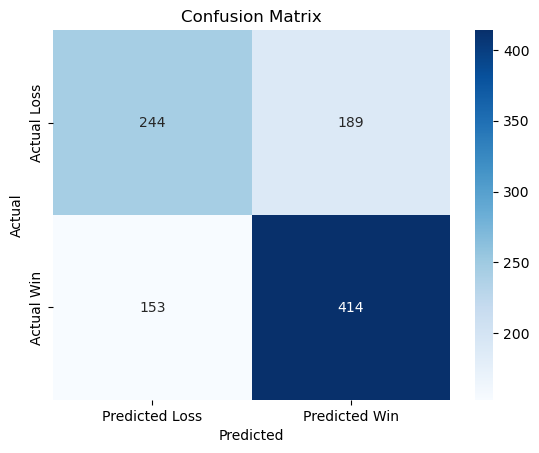

In [305]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)  # replace 'y_test' with your true labels

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Loss", "Predicted Win"], yticklabels=["Actual Loss", "Actual Win"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

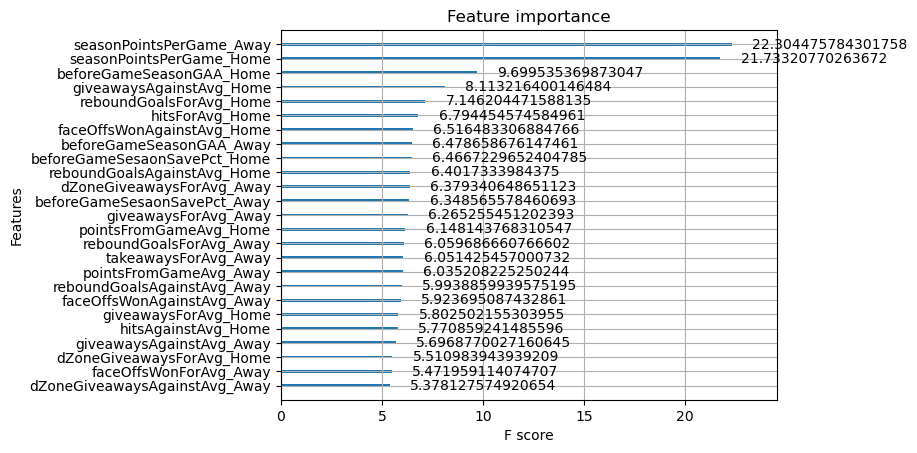

In [306]:
from xgboost import plot_importance

# Add feature names to model
model.get_booster().feature_names = feature_names

# Plot feature importance
plot_importance(model, importance_type='gain', max_num_features=min(X_train_prepared.shape[1], 25))  
# 'weight', 'gain', 'cover' are possible importance types
plt.show()

In [307]:
# Prepare inference data
X = df_test[best_cols].copy()
X_test_prepared= num_pipeline.transform(X)

In [308]:
# Prepare list of results
results_dict = {1 : 'win', 0 : 'lose'}

home_team_results = list(model.predict(X_test_prepared))

for i, item in enumerate(home_team_results):
    if item in results_dict:
        home_team_results[i] = results_dict[item]


In [309]:
# Create dataframe to map team names and nightly odds
df_results = pd.DataFrame(columns=['home_team_short','home_team_long','home_team_odds','home_team_result',
                                   'away_team_short','away_team_long','away_team_odds'])

In [310]:
teams_dict = {'ANA':'Anaheim Ducks',
'BOS':'Boston Bruins',
'BUF':'Buffalo Sabres',
'CGY':'Calgary Flames',
'CAR':'Carolina Hurricanes',
'CHI':'Chicago Blackhawks',
'COL':'Colorado Avalanche',
'CBJ':'Columbus Blue Jackets',
'DAL':'Dallas Stars',
'DET':'Detroit Red Wings',
'EDM':'Edmonton Oilers',
'FLA':'Florida Panthers',
'LAK':'Los Angeles Kings',
'MIN':'Minnesota Wild',
'MTL':'Montréal Canadiens',
'NSH':'Nashville Predators',
'NJD':'New Jersey Devils',
'NYI':'New York Islanders',
'NYR':'New York Rangers',
'OTT':'Ottawa Senators',
'PHI':'Philadelphia Flyers',
'PIT':'Pittsburgh Penguins',
'SJS':'San Jose Sharks',
'SEA':'Seattle Kraken',
'STL':'St Louis Blues',
'TBL':'Tampa Bay Lightning',
'TOR':'Toronto Maple Leafs',
'UTA':'Utah Hockey Club',
'VAN':'Vancouver Canucks',
'VGK':'Vegas Golden Knights',
'WPG':'Winnipeg Jets',
'WSH':'Washington Capitals'}

In [311]:
away_teams = df_test.iloc[:,0].tolist()
home_teams = df_test.iloc[:,1].tolist()

In [312]:
df_results['home_team_short'] = home_teams
df_results['home_team_long'] = df_results['home_team_short'].map(teams_dict)
df_results['home_team_result'] = home_team_results
df_results['away_team_short'] = away_teams
df_results['away_team_long'] = df_results['away_team_short'].map(teams_dict)

In [313]:
from datetime import datetime, timedelta, timezone

# Create datetime to only pull todays games

current_date = datetime.today().strftime('%Y-%m-%d')
#commence_time_to = '2024-09-27T00:15:00Z'


current_datetime = datetime.now(timezone.utc)
# Set limit as tomorrow at 6am to include any late eastern time games
tomorrow_datetime = current_datetime + timedelta(days=1)
custmo_tomorrow_datetime = tomorrow_datetime.replace(hour=6,minute=0,second=0,microsecond=0)

# Convert to ISO 8601 format
commence_time_to = custmo_tomorrow_datetime.isoformat().replace('+00:00','Z')

In [314]:
from datetime import datetime

# Pull game odds from odds-api
odds_URL = 'https://api.the-odds-api.com/v4/sports/icehockey_nhl/odds/?'\
           'apiKey=94588626e22d896e9f196d0745f00928&bookmakers=draftkings&markets=h2h&'\
           f'oddsFormat=american&commenceTimeTo={commence_time_to}'

print(f'Hitting this url: {odds_URL}')

Hitting this url: https://api.the-odds-api.com/v4/sports/icehockey_nhl/odds/?apiKey=94588626e22d896e9f196d0745f00928&bookmakers=draftkings&markets=h2h&oddsFormat=american&commenceTimeTo=2025-01-30T06:00:00Z


In [315]:
# API is limited to 500 pulls per month so only use when needed
#result = requests.get(odds_URL)

# Check if the request was successful
if result.status_code == 200:
    # Parse the JSON response
    data = result.json()
    
    teams_of_interest = ['Dallas Cowboys','New York Giants']
    odds_list = []
    teams_list = []
    # Extracting 'price' values from the JSON data
    for game in data:
        bookmakers = game.get('bookmakers', [])
        if bookmakers:
            markets = bookmakers[0].get('markets', [])
            if markets:
                outcomes = markets[0].get('outcomes', [])
                if outcomes:
                    for outcome in outcomes:
                        team_name = outcome.get('name', 'N/A')
                        if team_name not in teams_of_interest:  # Check if team is in the list
                            price = outcome.get('price', 'N/A')
                            odds_list.append(price)
                            teams_list.append(team_name)
                            #print(f'Team: {team_name}, Price: {price}')
else:
    print(f"Failed to retrieve data. Status code: {result.status_code}")

In [316]:
# Create dataframe with games, predictions, and odds
odds_dict = dict(zip(teams_list,odds_list))

df_results['home_team_odds'] = df_results['home_team_long'].map(odds_dict)
df_results['away_team_odds'] = df_results['away_team_long'].map(odds_dict)

In [317]:
df_results.head(df_results.shape[0])

,home_team_short,home_team_long,home_team_odds,home_team_result,away_team_short,away_team_long,away_team_odds
0,FLA,Florida Panthers,-155,win,LAK,Los Angeles Kings,130
1,TOR,Toronto Maple Leafs,-162,win,MIN,Minnesota Wild,136
2,NJD,New Jersey Devils,-185,win,PHI,Philadelphia Flyers,154
3,UTA,Utah Hockey Club,-142,win,PIT,Pittsburgh Penguins,120
4,NSH,Nashville Predators,-142,win,VAN,Vancouver Canucks,120
